In [1]:
from fileinput import filename
import os
import random
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score
from utils import settings as settings
import pandas as pd
from evaluation.metrics import accuracy
from evaluation.conf_matrix import create_conf_matrix
from loader.Preprocessor import Preprocessor
from models.JensModel import JensModel
from models.RainbowModel import RainbowModel
from models.ResNetModel import ResNetModel
from models.ResNetModel_Multimodal import ResNetModelMultimodal
from models.LeanderDeepConvLSTM import LeanderDeepConvLSTM
from utils.filter_activities import filter_activities
from utils.folder_operations import new_saved_experiment_folder
from utils.DataConfig import Sonar22CategoriesConfig, OpportunityConfig, SonarConfig, LabPoseConfig
from tensorflow.keras.layers import (Dense)
from utils.Recording import Recording
import matplotlib.pyplot as plt
import utils.DataConfig
from pose_sequence_loader import *
from multiprocessing import Pool

In [2]:
import utils.DataConfig
import importlib
importlib.reload(utils.DataConfig)
from utils.DataConfig import Sonar22CategoriesConfig, OpportunityConfig, SonarConfig, LabPoseConfig

# Init
# TODO: refactor, find out why confusion matrix sometimes shows different results than accuracy
# TODO: - make train and test datasets evenly distributed
#       - make 
""" 
Number of recordings per person
{'connie.csv': 6, 'alex.csv': 38, 'trapp.csv': 9, 'anja.csv': 13, 'aileen.csv': 52, 'florian.csv': 16, 'brueggemann.csv': 36, 'oli.csv': 20, 'rauche.csv': 9, 'b2.csv': 6, 'yvan.csv': 8, 'christine.csv': 7, 'mathias.csv': 2, 'kathi.csv': 17}
"""

data_config = LabPoseConfig(dataset_path='/dhc/groups/bp2021ba1/data/lab_data_filtered_without_null')#OpportunityConfig(dataset_path='/dhc/groups/bp2021ba1/data/opportunity-dataset')
#data_config = SonarConfig(dataset_path='/dhc/groups/bp2021ba1/data/lab_data')#OpportunityConfig(dataset_path='/dhc/groups/bp2021ba1/data/opportunity-dataset')
settings.init(data_config)
random.seed(1678978086101)

k_fold_splits = 5
numEpochs = 10
window_size = 600

# LOAD DATA
recordings = settings.DATA_CONFIG.load_dataset()#limit=3)
recordings = Preprocessor().our_preprocess(recordings)


Loading recording 0_orhan_1652085453257.csv, 1 / 51
3
Loading recording 1_orhan_1651673896419.csv, 2 / 51
3
Loading recording 2_alex_1652878074983.csv, 3 / 51
3
Loading recording 3_daniel_1652429334344.csv, 4 / 51
6
Loading recording 4_lucas_1651566794296.csv, 5 / 51
1
Loading recording 5_orhan_1653467107120.csv, 6 / 51
3
Loading recording 6_orhan_1652086187708.csv, 7 / 51
1
Loading recording 7_marco_1651225541980.csv, 8 / 51
3
Loading recording 8_felix_1651152283882.csv, 9 / 51
5
Loading recording 9_orhan_1653481329073.csv, 10 / 51
8
Loading recording 10_valentin_1652869027863.csv, 11 / 51
3
Loading recording 11_orhan_1651674660480.csv, 12 / 51
6
Loading recording 12_orhan_1653480087545.csv, 13 / 51
3
Loading recording 13_orhan_1651674075450.csv, 14 / 51
10
Loading recording 14_franz_1653471714380.csv, 15 / 51
1
Loading recording 15_felix_1651154555588.csv, 16 / 51
1
Loading recording 16_kirill_1651147138832.csv, 17 / 51
1
Loading recording 17_orhan_1653465446990.csv, 18 / 51
8
Loadin

In [3]:
# import pose_sequence_loader
# import importlib
# importlib.reload(pose_sequence_loader)

# from pose_sequence_loader import *
# from multiprocessing import Pool
# import tqdm

def process_recording(recording_with_index):
    i = recording_with_index[0]
    recording = recording_with_index[1]
    pose_frame = get_poseframe(recording, "/dhc/groups/bp2021ba1/data/lab_data")
    
    print(f"Pose Frame added to Recording {i+1}/{len(recordings)}  ")
    return pose_frame

# pose_frames = []
# for i, k in list(enumerate(recordings)):
#     pose_frames.append(process_recording((i,k)))

pool = Pool()
pose_frames = pool.map(process_recording, list(enumerate(recordings)), 1)
pool.close()
pool.join()

for i, pose_frame in enumerate(pose_frames):
    recordings[i].pose_frame = pose_frame

Recording 1652429334344: Metadata has less than 2 Activities. Returning empty pose frame (!)
Pose Frame added to Recording 4/51  
Recording 1651674075450: Metadata has less than 2 Activities. Returning empty pose frame (!)
Pose Frame added to Recording 14/51  
Recording 1651674660480: Activity TimeStamps of Frame & Metadata significantly shifted. Returning empty pose frame (!)
Pose Frame added to Recording 12/51  
Recording 1653480087545: Activity TimeStamps of Frame & Metadata significantly shifted. Returning empty pose frame (!)
Pose Frame added to Recording 13/51  
Recording 1652428200498: Activity TimeStamps of Frame & Metadata significantly shifted. Returning empty pose frame (!)
Pose Frame added to Recording 19/51  
Recording 1651149389351: Metadata has less than 2 Activities. Returning empty pose frame (!)
Pose Frame added to Recording 29/51  
Recording 1651152887499: Activity TimeStamps of Frame & Metadata significantly shifted. Returning empty pose frame (!)
Pose Frame added t

In [4]:
initialLength = len(recordings)
recordings = list(filter(
    lambda recording: not recording.pose_frame.empty, 
    recordings
))
print(f"Filtered out {initialLength - len(recordings)} Recordings (!)")

print("==> APPENDING POSE FRAMES DONE")

Filtered out 10 Recordings (!)
==> APPENDING POSE FRAMES DONE


In [5]:
# CONFIG TRAINING

window_size = 100
n_sensor_features = recordings[0].sensor_frame.shape[1]
n_pose_features = recordings[0].pose_frame.shape[1]
print(f"Sensor features: {n_sensor_features},  Pose features: {n_pose_features}")
n_outputs = settings.DATA_CONFIG.n_activities()

# Create Folder, save model export and evaluations there
experiment_folder_path = new_saved_experiment_folder(
    "multiModal_alex"
)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def evaluate(y_test_pred: np.ndarray, y_test_true: np.ndarray, confusionMatrixFileName=None, confusionMatrixTitle="") -> tuple[float, float,float, np.ndarray]:
    acc = accuracy(y_test_pred, y_test_true)
    if confusionMatrixFileName:
        create_conf_matrix(
            experiment_folder_path, y_test_pred, y_test_true, 
            file_name = confusionMatrixFileName, title=confusionMatrixTitle+", acc:"+str(int(acc*10000)/100)+"%"
            # label_mapping = {value: key for key, value in data_config.category_labels.items()}
    ) 
    f1_macro = f1_score(np.argmax(y_test_true, axis=1), np.argmax(y_test_pred, axis=1), average="macro")   
    f1_weighted = f1_score(np.argmax(y_test_true, axis=1), np.argmax(y_test_pred, axis=1), average="weighted")    
    return acc, f1_macro, f1_weighted, y_test_true

def save_prediction(y_test_pred: np.ndarray, y_test_true: np.ndarray, acc, f1_macro, f1_weighted, file_name: str):
    with open(os.path.join(experiment_folder_path, f"{file_name}.json"), "w+") as file:
        json_dict = {
            'Predicted Labels': y_test_pred,
            'Actual Lables': y_test_true,
            'Accuracy': acc,
            'F1 Macro': f1_macro,
            'F1 Weighted':f1_weighted
        }
        
        json.dump(json_dict, file, cls=NumpyEncoder)


def instanciateModel(use_sensor_frame = True, use_pose_frame = False) -> ResNetModelMultimodal:
    n_features = 0
    n_features += n_sensor_features if (use_sensor_frame) else 0
    n_features += n_pose_features if (use_pose_frame) else 0

    #return ResNetModelMultimodal(
    return LeanderDeepConvLSTM(
        n_epochs=numEpochs,
        window_size=window_size,
        n_features=n_features,
        n_outputs=n_outputs,
        batch_size=64,
        use_sensor_frame=use_sensor_frame,
        use_pose_frame=use_pose_frame,
        verbose = True
    )

Sensor features: 70,  Pose features: 24




==== Sensor Features: True   Pose Features: False ====


2022-06-02 20:21:46.493595: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Building model for 100 timesteps (window_size) and 70 features

Windowizing: 1043193 Timesteps  -  4h 46m 
Windowizing done: 20255 Windows
Epoch 1/10
507/507 [==============================] - 11s 18ms/step - loss: 1.1402 - accuracy: 0.5998 - val_loss: 0.8751 - val_accuracy: 0.6887
Epoch 2/10
507/507 [==============================] - 9s 18ms/step - loss: 0.7494 - accuracy: 0.7399 - val_loss: 0.7002 - val_accuracy: 0.7549
Epoch 3/10
507/507 [==============================] - 10s 19ms/step - loss: 0.5769 - accuracy: 0.7996 - val_loss: 0.6340 - val_accuracy: 0.7820
Epoch 4/10
507/507 [==============================] - 10s 19ms/step - loss: 0.4379 - accuracy: 0.8519 - val_loss: 0.5376 - val_accuracy: 0.8176
Epoch 5/10
507/507 [==============================] - 9s 18ms/step - loss: 0.3282 - accuracy: 0.8878 - val_loss: 0.4706 - val_accuracy: 0.8408
Epoch 6/10
507/507 [==============================] - 9s 19ms/step - loss: 0.2389 - accuracy: 0.9240 - val_loss: 0.4784 - val_accuracy: 0.8460


<Figure size 432x288 with 0 Axes>

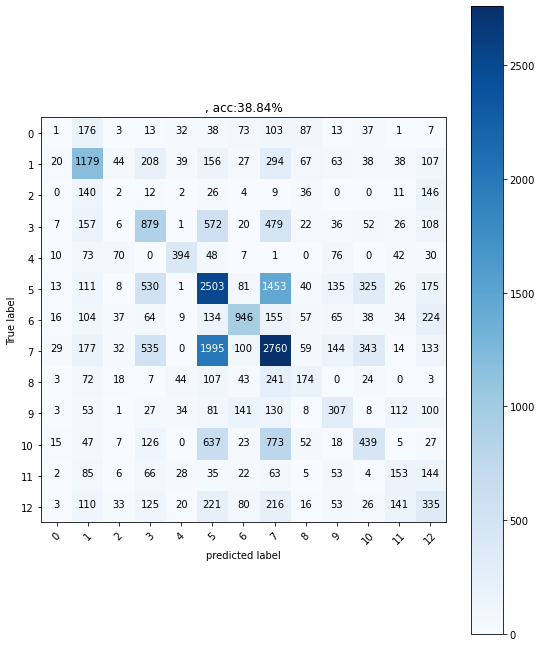

In [6]:
# TRAIN AND PREDICT
multiModals = [(True, False), (True, True), (False, True)]
for modality_index, (use_sensor_frame, use_pose_frame) in enumerate(multiModals):
    print(f"\n\n==== Sensor Features: {use_sensor_frame}   Pose Features: {use_pose_frame} ====")
    model = instanciateModel(use_sensor_frame=use_sensor_frame, use_pose_frame=use_pose_frame)
    model.n_epochs = numEpochs
    model.model.save_weights("ckpt")

    confusion_y_test_pred = None
    confusion_y_test_actual = None
    avg_acc = avg_f1_macro = avg_f1_weighted = divider = 0
    k_fold = KFold(n_splits=k_fold_splits, random_state=42, shuffle=True)
    for k_fold_index, (train_indices, test_indices) in enumerate(k_fold.split(recordings)):
        model.model.load_weights("ckpt")
        
        recordingsTrain = [recordings[ind] for ind in train_indices.astype(int)]
        recordingsTest = [recordings[ind] for ind in test_indices.astype(int)]

        x_train, y_train = model.windowize_convert_fit(recordingsTrain)

        x_test, y_test_actual = model.windowize_convert(recordingsTest)
        y_test_pred = model.predict(x_test)

        confusion_y_test_pred = y_test_pred if confusion_y_test_pred is None else np.append(confusion_y_test_pred, y_test_pred, axis=0)
        confusion_y_test_actual = y_test_actual if confusion_y_test_actual is None else np.append(confusion_y_test_actual, y_test_actual, axis=0)

        acc, f1_macro, f1_weighted, _ = evaluate(
            y_test_pred, 
            y_test_actual
        )

        weight = len(confusion_y_test_actual)
        avg_acc += acc * weight
        avg_f1_macro += f1_macro * weight
        avg_f1_weighted += f1_weighted * weight
        divider += weight

        print(f"=> K-Fold {k_fold_index+1}/{k_fold_splits}: acc: {acc}  f1 macro: {f1_macro}  f1 weighted: {f1_weighted}\n")

    avg_acc = avg_acc / divider
    avg_f1_macro = avg_f1_macro / divider
    avg_f1_weighted = avg_f1_weighted / divider

    save_prediction(
            confusion_y_test_pred, confusion_y_test_actual, 
            avg_acc, avg_f1_macro, avg_f1_weighted,
            f"Data {'SENSOR' if use_sensor_frame else 'x'} - {'POSE' if use_pose_frame else 'x'}"
        )
    _, _, _, _ = evaluate(
            confusion_y_test_pred, confusion_y_test_actual, 
            confusionMatrixFileName=f"Confusion {'SENSOR' if use_sensor_frame else 'x'} - {'POSE' if use_pose_frame else 'x'}"
        )

    print(f"\n\n==== Results ====")
    print(f"Accuracy: {avg_acc}")
    print(f"F1 Macro: {avg_f1_macro}")
    print(f"F1 Weighted: {avg_f1_weighted}")

In [7]:
# for recording in recordings:
#    print(recording.sensor_frame.shape[0], recording.pose_frame.shape[0], recording.time_frame.shape[0], recording.activities.shape[0])

#print(recordings[0].pose_frame)

# import models.ResNetModel_Multimodal
# import importlib
# importlib.reload(models.ResNetModel_Multimodal)

# from models.ResNetModel_Multimodal import ResNetModelMultimodal

import models.LeanderDeepConvLSTM
import importlib
importlib.reload(models.LeanderDeepConvLSTM)

from models.LeanderDeepConvLSTM import LeanderDeepConvLSTM


In [8]:
label = np.array([
            0.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
        ])
count = 0
for l in list(confusion_y_test_actual):
    should_continue = False
    for index, ll in enumerate(l):
        if label[index] != ll:
            should_continue = True
    if not should_continue:
        count += 1
count

2280

In [9]:
recordings[0].pose_frame.to_csv("/dhc/groups/bp2021ba1/alex/UnicornML/src/pose_frame.csv")